In [5]:
import os
import argparse
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
torch.manual_seed(1000)
np.random.seed(1000)

parser = argparse.ArgumentParser('ODE demo')
parser.add_argument('--method', type=str, choices=['dopri5', 'adams'], default='dopri5')
parser.add_argument('--data_size', type=int, default=1000)
parser.add_argument('--batch_time', type=int, default=15)
parser.add_argument('--batch_size', type=int, default=100)
parser.add_argument('--niters', type=int, default=2000)
parser.add_argument('--test_freq', type=int, default=20)
parser.add_argument('--viz', action='store_true')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--adjoint', action='store_true')

# Parse arguments when running in Jupyter notebook
args = parser.parse_args(args=[])

if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

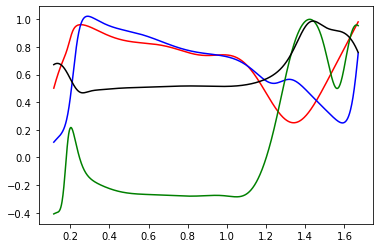

In [6]:
interpolMeanNN = nn.Sequential(
    nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
    ).to(torch.float64)

interpolVarNN = nn.Sequential(
    nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
    ).to(torch.float64)

interpolSkwNN = nn.Sequential(
    nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
    ).to(torch.float64)

interpolKurtNN = nn.Sequential(
    nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
    ).to(torch.float64)

interpolMeanNN.load_state_dict(torch.load("/home/ponnana/PhD/Projects/NeuralODE/240313/Interpolation/interpolMean_64_64.pth"))
interpolVarNN.load_state_dict(torch.load("/home/ponnana/PhD/Projects/NeuralODE/240313/Interpolation/interpolVar_64_64.pth"))
interpolSkwNN.load_state_dict(torch.load("/home/ponnana/PhD/Projects/NeuralODE/240313/Interpolation/interpolSkw_64_64.pth"))
interpolKurtNN.load_state_dict(torch.load("/home/ponnana/PhD/Projects/NeuralODE/240313/Interpolation/interpolKurt_64_64.pth"))

interpolMeanNN.eval()
interpolVarNN.eval()
interpolSkwNN.eval()
interpolKurtNN.eval()

x_test = torch.unsqueeze(torch.linspace(0.1156, 1.670, 1000), dim=1).double()
y_test1 = interpolMeanNN(x_test)
y_test2 = interpolVarNN(x_test)
y_test3 = interpolSkwNN(x_test)
y_test4 = interpolKurtNN(x_test)


plt.plot(x_test, y_test1.detach().numpy(), 'r')
plt.plot(x_test, y_test2.detach().numpy(), 'b')
plt.plot(x_test, y_test3.detach().numpy(), 'g')
plt.plot(x_test, y_test4.detach().numpy(), 'k')
plt.show()

In [62]:
def myDer(NN,time,dt):
    dNN_dt = (NN(time+dt)-NN(time-dt))/(2*dt)
    return dNN_dt

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.misc import derivative

matrix= scipy.io.loadmat("/home/ponnana/PhD/Yinling_copy/data_new.mat")

m = matrix["data_new"][:,0]
v =  matrix["data_new"][:,1]
s = matrix["data_new"][:,2]
k = matrix["data_new"][:,3]

tExp = [0.01058, 0.03158, 0.05258, 0.07358, 0.09458, 0.1156, 0.1366, 0.1576, 0.1786, 0.1996, 0.2206,
          0.2300, 0.2756, 0.3316, 0.3876, 0.4436, 0.4496, 0.5556, 0.6116, 0.6676, 0.7206, 0.7796, 0.8356,
          0.8916, 0.9476, 1.004, 1.060, 1.105, 1.124, 1.153, 1.182, 1.211, 1.240, 1.269, 1.298, 1.327,
          1.356, 1.385, 1.414, 1.443, 1.472, 1.501, 1.530, 1.559, 1.588, 1.617, 1.646, 1.670]

tExp = np.array(tExp)


t1,t2 = 0.24,1.1
xExp = np.concatenate((matrix["data_new"], tExp.reshape(-1,1)), axis=1)
# xExp = xExp.astype(double)

maxValues = np.max(xExp,axis=0)
maxValues[-1]=1
xExpNormal = xExp/maxValues
truncIndex = np.where(xExpNormal[:,1]>=0.0999)
xExpTruncNormal = xExpNormal[truncIndex,:]
xExpTruncNormal = np.squeeze(xExpTruncNormal)

tExpTrunc = xExpTruncNormal[:,-1]

tTrain = np.linspace(np.min(tExpTrunc), np.max(tExpTrunc), args.data_size)
tTrain = torch.unsqueeze(torch.tensor(tTrain),dim= 1)

In [64]:
dm_dt = myDer(interpolMeanNN, tTrain, 1e-6)
dv_dt = myDer(interpolVarNN, tTrain, 1e-6)
ds_dt = myDer(interpolSkwNN, tTrain, 1e-6)
dk_dt = myDer(interpolKurtNN, tTrain, 1e-6)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


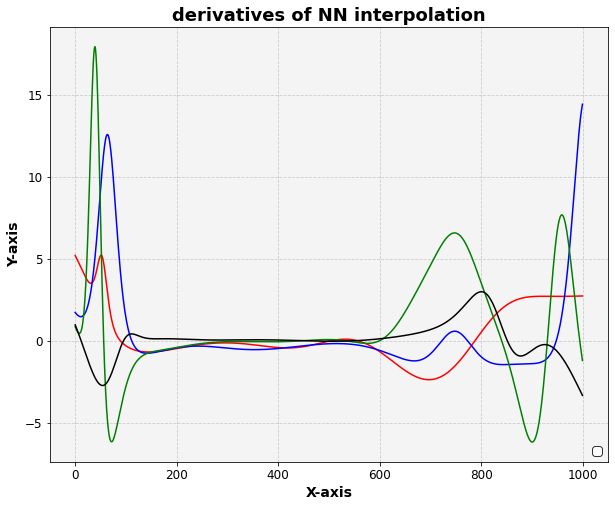

In [65]:
fig, ax = plt.subplots(figsize=(10, 8))

plt.plot(dm_dt.detach().numpy(),'r')
plt.plot(dv_dt.detach().numpy(),'b')
plt.plot(ds_dt.detach().numpy(),'g')
plt.plot(dk_dt.detach().numpy(),'k')

ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

# Customize fonts and sizes
ax.set_title("derivatives of NN interpolation", fontsize=18, fontweight='bold')
ax.set_xlabel("X-axis", fontsize=14, fontweight='bold')
ax.set_ylabel("Y-axis", fontsize=14, fontweight='bold')

# Increase tick label font size
ax.tick_params(axis='both', labelsize=12)

# Customize the appearance of the legend
legend = ax.legend(loc='lower right', fontsize=12)
legend.get_frame().set_edgecolor('black')
ax.set_facecolor('#F4F4F4')


# Show the plot
plt.show()
